In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

C:\Users\user\anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
df = pd.read_excel('Total_final.xlsx', index_col='TS', parse_dates=True, dtype={'Value':float})
df.drop(['Unnamed: 0','Unnamed: 0.1', 'Time', 'Max Value','Date'], axis=1, inplace=True)
df.rename(columns={'TS':'ds','Value':'y'},inplace=True)

In [3]:
df_day=df.resample(rule='D').mean()
df_day=df_day.reset_index()
df_day.columns
df_day.rename(columns={'TS':'ds','Value':'y'},inplace=True)

In [4]:
#df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df_day)
future = m.make_future_dataframe(periods=336) #366

In [5]:
future

,ds
0,2019-10-01
1,2019-10-02
2,2019-10-03
3,2019-10-04
4,2019-10-05
...,...
668,2021-07-30
669,2021-07-31
670,2021-08-01
671,2021-08-02


### Modeling Holidays and Special Events
If you have holidays or other recurring events that you'd like to model, you must create a dataframe for them. It has two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns `lower_window` and `upper_window` which extend the holiday out to `[lower_window, upper_window]` days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you'd include `lower_window=-1,upper_window=0`. If you wanted to use Black Friday in addition to Thanksgiving, you'd include `lower_window=0,upper_window=1`. You can also include a column `prior_scale` to set the prior scale separately for each holiday, as described below.

Here we create a dataframe that includes the dates of all of Peyton Manning's playoff appearances:

In [6]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2019-02-15','2019-02-03','2019-02-04', '2019-02-05', '2020-01-24']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2018-09-24', '2019-09-11', '2019-09-12', '2019-09-13', '2020-10-01']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

Above we have included the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once the table is created, holiday effects are included in the forecast by passing them in with the `holidays` argument. Here we do it with the Peyton Manning data from the [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html):

In [7]:
m = Prophet(holidays=holidays)
forecast = m.fit(df_day).predict(future)

The holiday effect can be seen in the `forecast` dataframe:

In [8]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

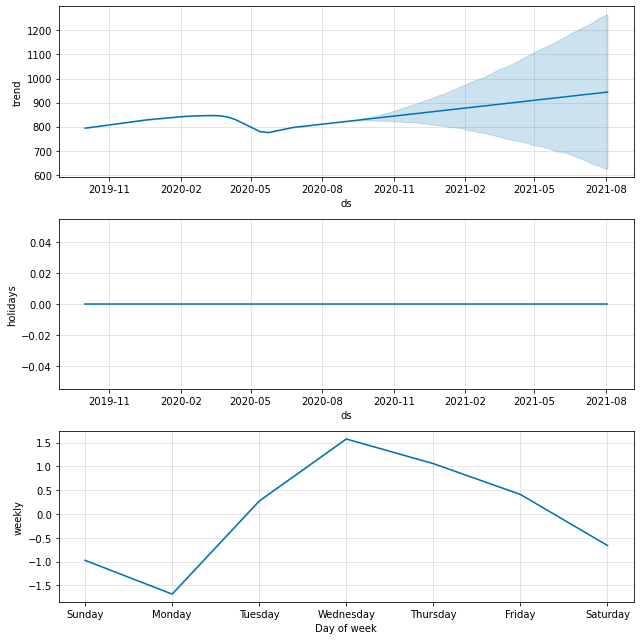

In [9]:
fig = m.plot_components(forecast)

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
%matplotlib inline

In [11]:
df_day['yhat_holiday'] = forecast['yhat']
rmse = np.sqrt(mean_squared_error(df_day['y'], df_day['yhat_holiday']))
rmse

14.64739616565087

Individual holidays can be plotted using the `plot_forecast_component` function (imported from `fbprophet.plot` in Python) like `plot_forecast_component(m, forecast, 'superbowl')` to plot just the superbowl holiday component.

### Built-in Country Holidays

You can use a built-in collection of country-specific holidays using the `add_country_holidays` method (Python) or function (R). The name of the country is specified, and then major holidays for that country will be included in addition to any holidays that are specified via the `holidays` argument described above:

In [12]:
"""
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)
"""

"\nm = Prophet(holidays=holidays)\nm.add_country_holidays(country_name='US')\nm.fit(df)\n"

You can see which holidays were included by looking at the `train_holiday_names` (Python) or `train.holiday.names` (R) attribute of the model:

In [13]:
"""m.train_holiday_names
"""

'm.train_holiday_names\n'

The holidays for each country are provided by the `holidays` package in Python. A list of available countries, and the country name to use, is available on their page: https://github.com/dr-prodigy/python-holidays. In addition to those countries, Prophet includes holidays for these countries: Brazil (BR), Indonesia (ID), India (IN), Malaysia (MY), Vietnam (VN), Thailand (TH), Philippines (PH), Turkey (TU), Pakistan (PK), Bangladesh (BD), Egypt (EG), China (CN), and Russian (RU).

In Python, most holidays are computed deterministically and so are available for any date range; a warning will be raised if dates fall outside the range supported by that country. In R, holiday dates are computed for 1995 through 2044 and stored in the package as `data-raw/generated_holidays.csv`. If a wider date range is needed, this script can be used to replace that file with a different date range: https://github.com/facebook/prophet/blob/master/python/scripts/generate_holidays_file.py.

As above, the country-level holidays will then show up in the components plot:

In [14]:
"""
forecast = m.predict(future)
fig = m.plot_components(forecast)
"""

'\nforecast = m.predict(future)\nfig = m.plot_components(forecast)\n'

### Fourier Order for Seasonalities

Seasonalities are estimated using a partial Fourier sum. See [the paper](https://peerj.com/preprints/3190/) for complete details, and [this figure on Wikipedia](https://en.wikipedia.org/wiki/Fourier_series#/media/File:Fourier_Series.svg) for an illustration of how a partial Fourier sum can approximate an aribtrary periodic signal. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. To illustrate this, consider the Peyton Manning data from the [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html). The default Fourier order for yearly seasonality is 10, which produces this fit:

In [15]:
from fbprophet.plot import plot_yearly

In [16]:
m = Prophet(yearly_seasonality=5).fit(df_day)

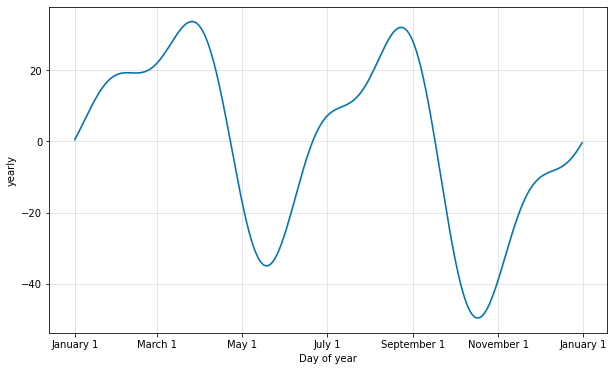

In [17]:
a = plot_yearly(m)

The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model, here it is increased to 20:

In [18]:
"""
%%R -w 9 -h 3 -u in
m <- prophet(df, yearly.seasonality = 20)
prophet:::plot_yearly(m)
"""

'\n%%R -w 9 -h 3 -u in\nm <- prophet(df, yearly.seasonality = 20)\nprophet:::plot_yearly(m)\n'

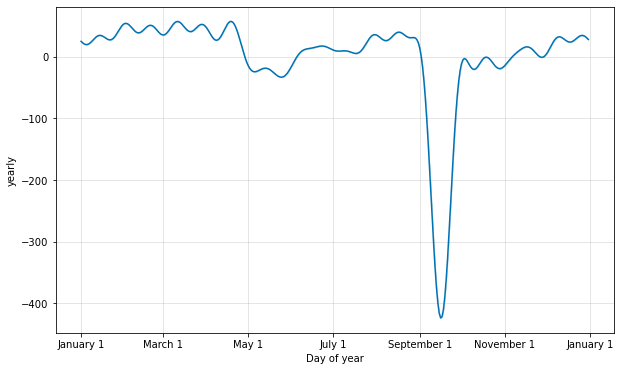

In [19]:
from fbprophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df_day)
a = plot_yearly(m)

Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: N Fourier terms corresponds to 2N variables used for modeling the cycle

### Specifying Custom Seasonalities

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method (Python) or function (R).

The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. An optional input to `add_seasonality` is the prior scale for that seasonal component - this is discussed below.

As an example, here we fit the Peyton Manning data from the [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html), but replace the weekly seasonality with monthly seasonality. The monthly seasonality then will appear in the components plot:

In [20]:
"""
%%R -w 9 -h 9 -u in
m <- prophet(weekly.seasonality=FALSE)
m <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)
m <- fit.prophet(m, df)
forecast <- predict(m, future)
prophet_plot_components(m, forecast)
"""

"\n%%R -w 9 -h 9 -u in\nm <- prophet(weekly.seasonality=FALSE)\nm <- add_seasonality(m, name='monthly', period=30.5, fourier.order=5)\nm <- fit.prophet(m, df)\nforecast <- predict(m, future)\nprophet_plot_components(m, forecast)\n"

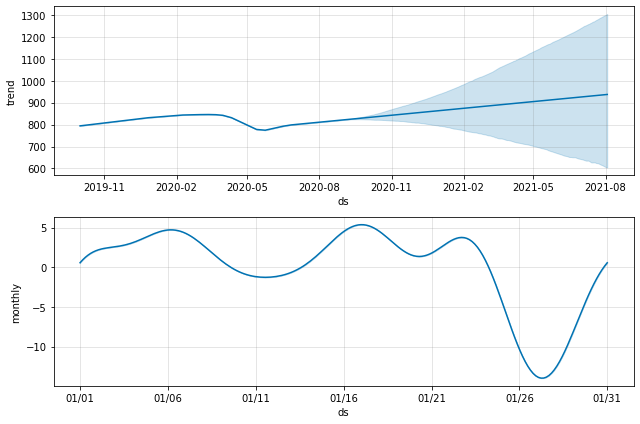

In [21]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df_day).predict(future)
fig = m.plot_components(forecast)

### Seasonalities that depend on other factors
In some instances the seasonality may depend on other factors, such as a weekly seasonal pattern that is different during the summer than it is during the rest of the year, or a daily seasonal pattern that is different on weekends vs. on weekdays. These types of seasonalities can be modeled using conditional seasonalities.

Consider the Peyton Manning example from the [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html). The default weekly seasonality assumes that the pattern of weekly seasonality is the same throughout the year, but we'd expect the pattern of weekly seasonality to be different during the on-season (when there are games every Sunday) and the off-season. We can use conditional seasonalities to construct separate on-season and off-season weekly seasonalities.

First we add a boolean column to the dataframe that indicates whether each date is during the on-season or the off-season:

In [22]:
%%R
is_nfl_season <- function(ds) {
  dates <- as.Date(ds)
  month <- as.numeric(format(dates, '%m'))
  return(month > 8 | month < 2)
}
df$on_season <- is_nfl_season(df$ds)
df$off_season <- !is_nfl_season(df$ds)


Error in df$ds : object of type 'closure' is not subsettable


PermissionError: [WinError 32] 다른 프로세스가 파일을 사용 중이기 때문에 프로세스가 액세스 할 수 없습니다: 'C:\\Users\\user\\AppData\\Local\\Temp\\tmpaqg9rhb4\\Rplots001.png'

In [ ]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)

Then we disable the built-in weekly seasonality, and replace it with two weekly seasonalities that have these columns specified as a condition. This means that the seasonality will only be applied to dates where the `condition_name` column is `True`. We must also add the column to the `future` dataframe for which we are making predictions.

In [ ]:
%%R -w 9 -h 12 -u in
m <- prophet(weekly.seasonality=FALSE)
m <- add_seasonality(m, name='weekly_on_season', period=7, fourier.order=3, condition.name='on_season')
m <- add_seasonality(m, name='weekly_off_season', period=7, fourier.order=3, condition.name='off_season')
m <- fit.prophet(m, df)

future$on_season <- is_nfl_season(future$ds)
future$off_season <- !is_nfl_season(future$ds)
forecast <- predict(m, future)
prophet_plot_components(m, forecast)

In [ ]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

Both of the seasonalities now show up in the components plots above. We can see that during the on-season when games are played every Sunday, there are large increases on Sunday and Monday that are completely absent during the off-season.

### Prior scale for holidays and seasonality
If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter `holidays_prior_scale`. By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects:

In [ ]:
%%R
m <- prophet(df, holidays = holidays, holidays.prior.scale = 0.05)
forecast <- predict(m, future)
forecast %>% 
  select(ds, playoff, superbowl) %>% 
  filter(abs(playoff + superbowl) > 0) %>%
  tail(10)

In [ ]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

The magnitude of the holiday effect has been reduced compared to before, especially for superbowls, which had the fewest observations. There is a parameter `seasonality_prior_scale` which similarly adjusts the extent to which the seasonality model will fit the data.

Prior scales can be set separately for individual holidays by including a column `prior_scale` in the holidays dataframe. Prior scales for individual seasonalities can be passed as an argument to `add_seasonality`. For instance, the prior scale for just weekly seasonality can be set using:

In [ ]:
%%R
m <- prophet()
m <- add_seasonality(
  m, name='weekly', period=7, fourier.order=3, prior.scale=0.1)

In [ ]:
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1)


### Additional regressors
Additional regressors can be added to the linear part of the model using the `add_regressor` method or function. A column with the regressor value will need to be present in both the fitting and prediction dataframes. For example, we can add an additional effect on Sundays during the NFL season. On the components plot, this effect will show up in the 'extra_regressors' plot:

In [ ]:
%%R -w 9 -h 12 -u in
nfl_sunday <- function(ds) {
  dates <- as.Date(ds)
  month <- as.numeric(format(dates, '%m'))
  as.numeric((weekdays(dates) == "Sunday") & (month > 8 | month < 2))
}
df$nfl_sunday <- nfl_sunday(df$ds)

m <- prophet()
m <- add_regressor(m, 'nfl_sunday')
m <- fit.prophet(m, df)

future$nfl_sunday <- nfl_sunday(future$ds)

forecast <- predict(m, future)
prophet_plot_components(m, forecast)

In [ ]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

NFL Sundays could also have been handled using the "holidays" interface described above, by creating a list of past and future NFL Sundays. The `add_regressor` function provides a more general interface for defining extra linear regressors, and in particular does not require that the regressor be a binary indicator. Another time series could be used as a regressor, although its future values would have to be known.

[This notebook](https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb) shows an example of using weather factors as extra regressors in a forecast of bicycle usage, and provides an excellent illustration of how other time series can be included as extra regressors.

The `add_regressor` function has optional arguments for specifying the prior scale (holiday prior scale is used by default) and whether or not the regressor is standardized - see the docstring with `help(Prophet.add_regressor)` in Python and `?add_regressor` in R. Note that regressors must be added prior to model fitting.

The extra regressor must be known for both the history and for future dates. It thus must either be something that has known future values (such as `nfl_sunday`), or something that has separately been forecasted elsewhere. Prophet will also raise an error if the regressor is constant throughout the history, since there is nothing to fit from it.

Extra regressors are put in the linear component of the model, so the underlying model is that the time series depends on the extra regressor as either an additive or multiplicative factor (see the next section for multiplicativity).